Linear Interpolation

In [1]:
import pandas as pd
import numpy as np
from support_fun import corruption, RMSE, draw

In [2]:
# Load the data
df = pd.read_excel('Dataset_RTsRTWINWeather_2018.xlsx', engine='openpyxl')[['timestamp', 'RoomTemperatureRT']]

In [3]:
# Set timestamp column to index
df.set_index('timestamp', inplace=True)

In [4]:
print(df.head()) #debugging

                     RoomTemperatureRT
timestamp                             
2018-05-20 00:00:00          23.584482
2018-05-20 00:01:00          23.586210
2018-05-20 00:02:00          23.584482
2018-05-20 00:03:00          23.581122
2018-05-20 00:04:00          23.576131


In [5]:
# Resample to 30 min
df_30min = df.asfreq(freq='30T')

/tmp/ipykernel_23638/4124092362.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_30min = df.asfreq(freq='30T')


In [6]:
# Remove nan values
df_30min.dropna(inplace=True)

In [7]:
# Get the timestamp index as an array
timestamp = df_30min.index.values

In [8]:
# Convert room temperature column to numpy
data_column = df_30min['RoomTemperatureRT'].values

In [9]:
# Reshape room temperature array to a day-to-day matrix
data = np.reshape(data_column, (int(data_column.shape[0] / 48), 48))

In [10]:
# Corrupt daily input data with a predefined corruption rate [0-1] and missing scenario [continuous/random]. Use the predefined function corruption.
data_corrupted, mask = corruption(input=data, corruption_rate=0.4, missing_scenario='continuous')

inp type float64


In [11]:
# Turn numpy matrix back into a pandas dataframe
df_corrupted = pd.DataFrame(data_corrupted)

In [12]:
# Fill the missing values using linear interpolation
df_corrupted_interpolate = df_corrupted.interpolate(axis=1)

In [13]:
# Apply back propagation to fill the remaining NaNs at the beginning of each row
df_corrupted_interpolate_bfill = df_corrupted_interpolate.bfill(axis=1)

In [14]:
# Apply forward propagation to fill the remaining NaNs at the end of each row
df_corrupted_interpolate_bfill_ffill = df_corrupted_interpolate_bfill.ffill(axis=1)


In [15]:
# Turn pandas dataframe back into a numpy matrix
data_imputed = df_corrupted_interpolate_bfill_ffill.values

In [16]:
# Compute the daily RMSEs on the corrupted data only and take the average. Use the predefined function RMSE.
average_error = RMSE(actual=data, imputed=data_imputed, corrupted_indices=mask)

In [17]:
# Print average RMSE
print("average error:", average_error)

average error: 0.4581373413597682


In [18]:
# Save the timestamp index  and the real, corrupted and imputed data to excel as xlsx file with columns. Name the file as 'LinearInterpolation_results.xlsx'
# Name the columns [['timestamp', 'real_data', 'data_corrupted', 'data_imputed']]
d = {'timestamp': timestamp, 'real_data': data.flatten(), 'data_corrupted': data_corrupted.flatten(), 'data_imputed': data_imputed.flatten()}
pd.DataFrame(data=d).to_excel('LinearInterpolation_results.xlsx')

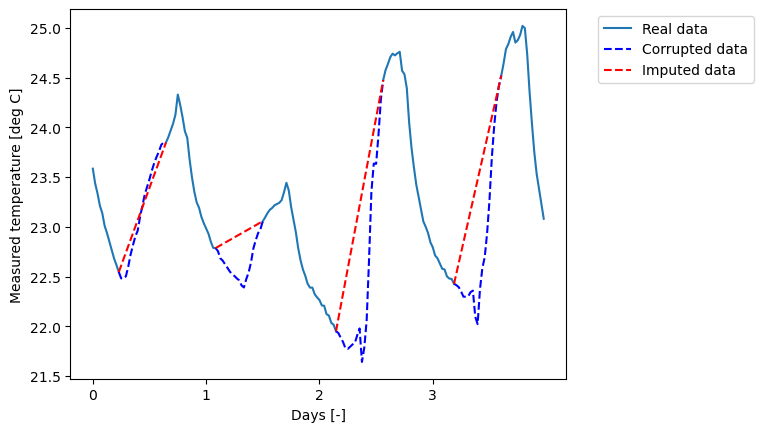

In [19]:
# Draw the first four days. Use the predefined function draw.
draw(file='LinearInterpolation_results.xlsx')

Mean Operation

In [20]:
import pandas as pd
import numpy as np
from support_fun import corruption, RMSE

In [21]:
# Load the data
df = pd.read_excel('Dataset_RTsRTWINWeather_2018.xlsx', engine='openpyxl')[['timestamp', 'RoomTemperatureRT']]

In [22]:
# Set timestamp column to index
df.set_index('timestamp', inplace=True)

In [23]:
# Resample to 30 min
df_30min = df.asfreq(freq='30T')

/tmp/ipykernel_23638/4124092362.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_30min = df.asfreq(freq='30T')


In [24]:
# Remove nan values
df_30min.dropna(inplace=True)

In [25]:
# Get the timestamp index as an array
timestamp = df_30min.index.values

In [26]:
# Convert room temperature column to numpy
data_column = df_30min['RoomTemperatureRT'].values

In [27]:
# Reshape room temperature array to a day-to-day matrix
data = np.reshape(data_column, (int(data_column.shape[0] / 48), 48))

In [28]:
# Corrupt daily input data with a predefined corruption rate [0-1] and missing scenario [continuous/random]. Use the predefined function corruption.
data_corrupted, mask = corruption(input=data, corruption_rate=0.4, missing_scenario='continuous')

inp type float64


In [29]:
# Turn numpy matrix back into a pandas dataframe
df_corrupted = pd.DataFrame(data_corrupted)

In [30]:
# Fill the missing values by computing the average between the back and forward propagated dataframes
df_corrupted_bfill = df_corrupted.bfill(axis=1)
df_corrupted_ffill = df_corrupted.ffill(axis=1)
df_corrupted_average = (df_corrupted_bfill + df_corrupted_ffill) / 2


In [31]:
# Apply back propagation to fill the remaining NaNs at the beginning of each row
df_corrupted_average_bfill = df_corrupted_average.bfill(axis=1)

In [32]:
# Apply forward propagation to fill the remaining NaNs at the end of each row
df_corrupted_average_bfill_ffill = df_corrupted_average_bfill.ffill(axis=1)

In [33]:
# Turn pandas dataframe back into a numpy matrix
data_imputed = df_corrupted_average_bfill_ffill.values

In [34]:
# Compute the daily RMSEs on the corrupted data only and take the average. Use the predefined function RMSE.
average_error = RMSE(actual=data, imputed=data_imputed, corrupted_indices=mask)

In [35]:
# Print average RMSE
print("average error:", average_error)

average error: 0.5826771419765819


In [36]:
# Save the timestamp index  and the real, corrupted and imputed data to excel as xlsx file with columns. Name the file as 'MeanOperation_results.xlsx'
# Name the columns [['timestamp', 'real_data', 'data_corrupted', 'data_imputed']]
d = {'timestamp': timestamp, 'real_data': data.flatten(), 'data_corrupted': data_corrupted.flatten(), 'data_imputed': data_imputed.flatten()}
pd.DataFrame(data=d).to_excel('MeanOperation_results.xlsx')

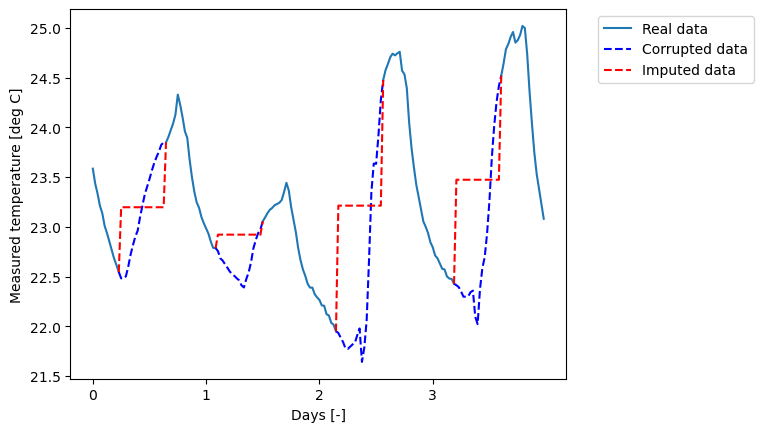

In [37]:
# Draw the first four days. Use the predefined function draw.
draw(file='MeanOperation_results.xlsx')

KNNimpute

In [38]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from support_fun import corruption, RMSE
from sklearn.preprocessing import StandardScaler

In [39]:
# Load the data
df = pd.read_excel('Dataset_RTsRTWINWeather_2018.xlsx', engine='openpyxl')[['timestamp', 'RoomTemperatureRT']]

In [40]:
# Set timestamp column to index
df.set_index('timestamp', inplace=True)

In [41]:
# Resample to 30 min
df_30min = df.asfreq(freq='30T')

/tmp/ipykernel_23638/4124092362.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_30min = df.asfreq(freq='30T')


In [42]:
# Remove NaNs
df_30min.dropna(inplace=True)

In [43]:
# Get the timestamp index as an array
timestamp = df_30min.index.values

In [44]:
# Convert room temperature column to numpy
data_column = df_30min['RoomTemperatureRT'].values

In [45]:
# Reshape room temperature array to a day-to-day matrix
data = np.reshape(data_column, (int(data_column.shape[0] / 48), 48))

In [46]:
# Corrupt daily input data with a predefined corruption rate [0-1] and missing scenario [continuous/random]. Use the predefined function corruption.
data_corrupted, mask = corruption(input=data, corruption_rate=0.4, missing_scenario='continuous')

inp type float64


In [47]:
# Create a CustomStandardScaler object to normalize the data with Z-score
scaler = StandardScaler()

In [48]:
# Fit the scaler to the dataset and transform it
data_corrupted_normalized = scaler.fit_transform(data_corrupted)

In [49]:
# Create a KNNImputer object with n_neighbors=default
imputer = KNNImputer(n_neighbors=5)

In [50]:
# Impute the missing values on the normalized dataset
data_imputed_normalized = imputer.fit_transform(data_corrupted_normalized)

In [51]:
# Inverse transform the imputed dataset to obtain the original scale
data_imputed = scaler.inverse_transform(data_imputed_normalized)

In [52]:
# Compute the daily RMSEs on the corrupted data only and take the average. Use the predefined function RMSE.
average_error = RMSE(actual=data, imputed=data_imputed, corrupted_indices=mask)

In [53]:
# Print average RMSE
print("average error:", average_error)

average error: 0.39470221422508817


In [54]:
# Save the timestamp index  and the real, corrupted and imputed data to excel as xlsx file with columns. Name the file as 'KNNimpute_results.xlsx'
# Name the columns [['timestamp', 'real_data', 'data_corrupted', 'data_imputed']]
d = {'timestamp': timestamp, 'real_data': data.flatten(), 'data_corrupted': data_corrupted.flatten(), 'data_imputed': data_imputed.flatten()}
pd.DataFrame(data=d).to_excel('KNNimpute_results.xlsx')

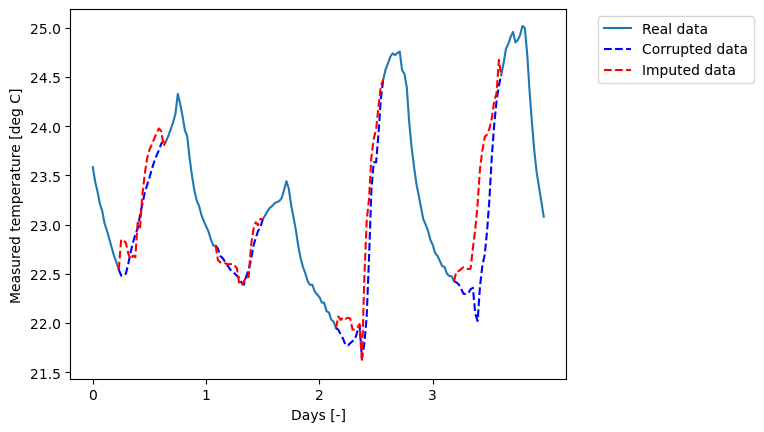

In [55]:
# Draw the first four days. Use the predefined function draw.
draw(file='KNNimpute_results.xlsx')

MissForest

In [56]:
import pandas as pd
import numpy as np
from Missforest_model import MissForest
from support_fun import corruption, RMSE
from support_fun import draw
import warnings
warnings.filterwarnings("ignore")

In [57]:
# Load the data
df = pd.read_excel('Dataset_RTsRTWINWeather_2018.xlsx', engine='openpyxl')[['timestamp', 'RoomTemperatureRT']]

In [58]:
# Set timestamp column to index
df.set_index('timestamp', inplace=True)

In [59]:
# Resample to 30 min
df_30min = df.asfreq(freq='30T')

In [60]:
# Remove NaNs
df_30min.dropna(inplace=True)

In [61]:
# Get the timestamp index as an array
timestamp = df_30min.index.values

In [62]:
# Remove NaNs
df_30min.dropna(inplace=True)

In [63]:
# Convert room temperature column to numpy
data_column = df_30min['RoomTemperatureRT'].values

In [64]:
# Reshape room temperature array to a day-to-day matrix
data = np.reshape(data_column, (int(data_column.shape[0] / 48), 48))

In [65]:
# Corrupt daily input data with a predefined corruption rate [0-1] and missing scenario [continuous/random]. Use the predefined function corruption.
data_corrupted, mask = corruption(input=data, corruption_rate=0.4, missing_scenario='continuous')

inp type float64


In [66]:
# Create a MissForest object with max_iter=default, n_estimators=default and random_state=default
imputer = MissForest(max_iter=10, n_estimators=100, random_state=0)

In [67]:
# Impute the missing values on the dataset
data_imputed = imputer.fit_transform(data_corrupted)

In [68]:
# Compute the daily RMSEs on the corrupted data only and take the average
average_error = RMSE(actual=data, imputed=data_imputed, corrupted_indices=mask)

In [69]:
# Print average RMSE. Use the predefined function RMSE.
print("average error:", average_error)

average error: 0.44455255681402345


In [70]:
# Save the timestamp index  and the real, corrupted and imputed data to excel as xlsx file with columns. Name the file as 'MissForest_results.xlsx'
# Name the columns [['timestamp', 'real_data', 'data_corrupted', 'data_imputed']]
d = {'timestamp': timestamp, 'real_data': data.flatten(), 'data_corrupted': data_corrupted.flatten(), 'data_imputed': data_imputed.flatten()}
pd.DataFrame(data=d).to_excel('MissForest_results.xlsx')

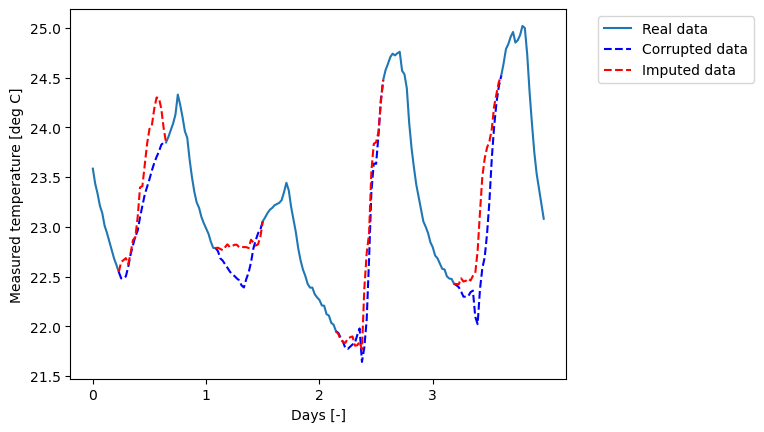

In [71]:
# Draw the first four days. Use the predefined function draw.
draw(file='MissForest_results.xlsx')